## Objective

This notebook covers the basic assumptions of Linear Regression. Additionally, how to investigate whether assumptions are met, how to diagnose problems, and how to address those problems are covered. 

---

## Imports

In [61]:
%matplotlib inline
import matplotlib, sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import scipy
from scipy.stats import normaltest
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

---

## Version Numbers

In [62]:
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd), 
             ('Scipy', scipy), ('Seaborn', sns), ('Sklearn', sklearn))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.5.4 |Anaconda custom (x86_64)| (default, Aug 14 2017, 12:43:10) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.13.1
Pandas Version: 0.20.3
Scipy Version: 0.19.1
Seaborn Version: 0.8.0
Sklearn Version: 0.19.0


---

## Let's build a class to capture statistics about our data from scratch which we'll use later

In [63]:
class Stats:
    
    def __init__(self, X, y, model):
        self.data = X
        self.target = y
        self.model = model
        self._dft = X.shape[0] - 1  ## degrees of freedom population dep. variable variance 
        self._dfe = X.shape[0] - X.shape[1] - 1  ## degrees of freedom population error variance
    
    def sse(self):
        '''returns sum of squared errors (model vs actual)'''
        squared_errors = (self.target - self.model.predict(self.data)) ** 2
        return np.sum(squared_errors)
        
    def sst(self):
        '''returns total sum of squared errors (actual vs avg(actual))'''
        avg_y = np.mean(self.target)
        squared_errors = (self.target - avg_y) ** 2
        return np.sum(squared_errors)
    
    def r_squared(self):
        '''returns calculated value of adjusted r^2'''
        return 1 - self.sse()/self.sst()
    
    def adj_r_squared(self):
        '''returns calculated value of adjusted r^2'''
        return 1 - (self.sse()/self._dfe) / (self.sst()/self._dft)

---

## Function to Pretty Print

In [64]:
def pretty_print_stats(stats_obj):
    '''returns report of statistics for a given model object'''
    items = ( ('sse:', stats_obj.sse()), ('sst:', stats_obj.sst()), 
             ('r^2:', stats_obj.r_squared()), ('adj_r^2:', stats_obj.adj_r_squared()) )
    for item in items:
        print('{0:8} {1:.4f}'.format(item[0], item[1]))

---

## Linear Regression Assumptions

1. Linear relationship between target and features
2. No outliers
3. No high-leverage points 
4. Homoscedasticity of error terms
5. Uncorrelated error terms 
6. Independent features

---

## [1] Linear relationship between target & features

In [65]:
# generate some dummy data
np.random.seed(20)
x = np.arange(20)
y = [x*2 + np.random.rand(1)*4 for x in range(20)]

In [66]:
# sklearn expects 2D array so have to reshape x
x_reshape = x.reshape(-1,1)
linear = LinearRegression()
linear.fit(x_reshape, y);

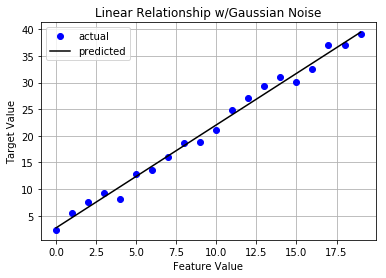

In [67]:
plt.plot(x, y, 'bo', label='actual')
plt.plot(x, linear.predict(x_reshape), 'k', label='predicted')
plt.title('Linear Relationship w/Gaussian Noise')
plt.xlabel('Feature Value')
plt.ylabel('Target Value')
plt.grid()
plt.legend();

In [68]:
# R^2 for linear model on linear data
linear.score(x_reshape, y)

0.99025267844275988

### Let's see 'Stats' in action

In [69]:
s1 = Stats(x_reshape, y, linear)

In [70]:
pretty_print_stats(s1)

sse:     24.3975
sst:     2502.9934
r^2:     0.9903
adj_r^2: 0.9897


### Potential Problem: Non-linear Relationship

In [71]:
y_nonlinear = [x**3 + np.random.rand(1)*10 for x in range(20)]

In [72]:
nonlinear = LinearRegression()
nonlinear.fit(x_reshape, y_nonlinear);

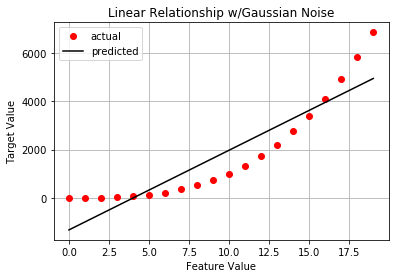

In [73]:
plt.plot(x, y_nonlinear, 'ro', label='actual')
plt.plot(x, nonlinear.predict(x_reshape), 'k', label='predicted')
plt.title('Linear Relationship w/Gaussian Noise')
plt.xlabel('Feature Value')
plt.ylabel('Target Value')
plt.grid()
plt.legend();

In [74]:
# R^2 for linear model on non-linear data
nonlinear.score(x_reshape, y_nonlinear)

0.83140839784707088

In [75]:
# suite of stats
s2 = Stats(x_reshape, y_nonlinear, nonlinear)
pretty_print_stats(s2)

sse:     14702044.1585
sst:     87205080.0323
r^2:     0.8314
adj_r^2: 0.8220


### Considerations

We can check to see if our model is capturing the underlying pattern effectively. Specifically, let's generate side-by-side **Residual Plots** for the linear case and the nonlinear case. 

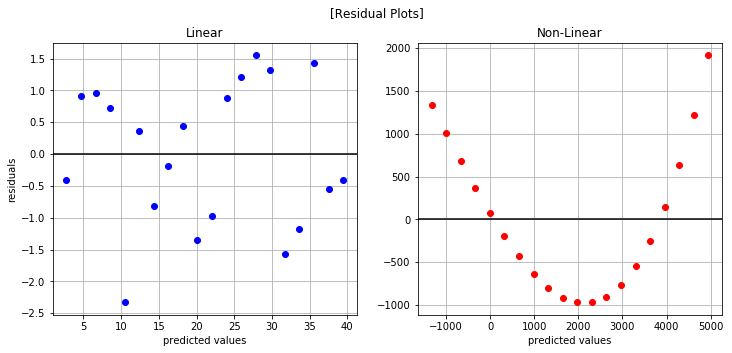

In [76]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False)
fig.suptitle('[Residual Plots]')
fig.set_size_inches(12,5)
axes[0].plot(linear.predict(x_reshape), y-linear.predict(x_reshape), 'bo')
axes[0].axhline(y=0, color='k')
axes[0].grid()
axes[0].set_title('Linear')
axes[0].set_xlabel('predicted values')
axes[0].set_ylabel('residuals')
axes[1].plot(nonlinear.predict(x_reshape), y_nonlinear-nonlinear.predict(x_reshape), 'ro')
axes[1].axhline(y=0, color='k')
axes[1].grid()
axes[1].set_title('Non-Linear')
axes[1].set_xlabel('predicted values');

### Plot Histograms of Residuals (are they Normally distributed?)

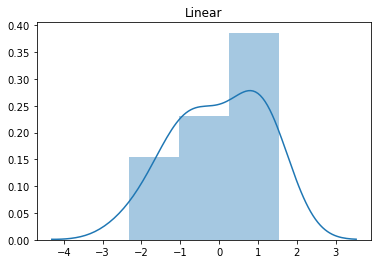

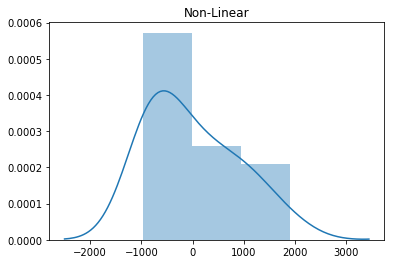

In [77]:
residuals_linear = y - linear.predict(x_reshape)
residuals_nlinear = y_nonlinear - nonlinear.predict(x_reshape)

sns.distplot(residuals_linear);
plt.title('Linear')
plt.show()
sns.distplot(residuals_nlinear)
plt.title('Non-Linear');

The 1st graph looks approximately Normal (aka Gaussian) while the 2nd shows a clear skew. But is there a more quantitative method to test for Normality?

In [78]:
normaltest(residuals_linear)

NormaltestResult(statistic=array([ 1.71234546]), pvalue=array([ 0.42478474]))

The null hypothesis is that the residual distribution is Normally distributed. Xince the p-value > 0.05, we cannot reject the null. In other words, the residuals are Normally distributed.

In [79]:
normaltest(residuals_nlinear)

NormaltestResult(statistic=array([ 2.20019716]), pvalue=array([ 0.33283827]))

Turns out the residuals for the non-linear function are Normally distributed as well, in this case.

### Takeaway

The linear data exhibits a fair amount of randomness centered around 0 indicating our model has captured nearly all the discernable pattern. On the other hand, the non-linear data shows a clear non-linear trend. In other words, using the non-linear data as-is with our linear model will result in a relatively poor model fit.

### Possible Solutions

1. Consider transforming the features 
2. Consider applying a different algorithm.

Let's see what we can do with polynomial regression in this scenario:

### Polynomial Regression

In [80]:
poly = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=False))])

In [81]:
poly.fit(x_reshape, y_nonlinear)

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False))])

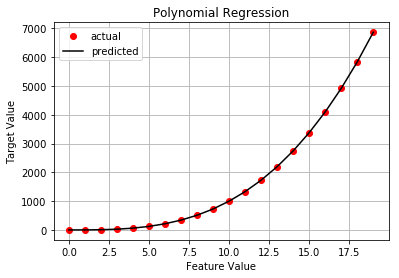

In [82]:
plt.plot(x, y_nonlinear, 'ro', label='actual')
plt.plot(x, poly.predict(x_reshape), 'k', label='predicted')
plt.title('Polynomial Regression')
plt.xlabel('Feature Value')
plt.ylabel('Target Value')
plt.grid()
plt.legend();

In [83]:
# R^2 for relaxed linear model on non-linear data
poly.score(x_reshape, y_nonlinear)

0.999999074678664

In [84]:
# suite of stats
s3 = Stats(x_reshape, y_nonlinear, poly)
pretty_print_stats(s3)

sse:     80.6927
sst:     87205080.0323
r^2:     1.0000
adj_r^2: 1.0000


---

## [2] No outliers

In [85]:
# generate some dummy data
np.random.seed(20)
x = np.arange(20)
y = [x*2 + np.random.rand(1)*4 for x in range(20)]
y_outlier = y.copy()
y_outlier[8] = np.array([38])  ## insert outlier

In [86]:
# sklearn expects 2D array so have to reshape x
x_reshape = x.reshape(-1,1)

linear_nooutlier = LinearRegression()
linear_nooutlier.fit(x_reshape, y);

linear_outlier = LinearRegression()
linear_outlier.fit(x_reshape, y_outlier);

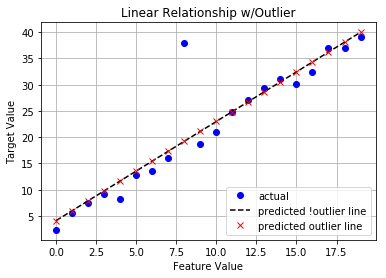

In [87]:
plt.plot(x, y_outlier, 'bo', label='actual')
plt.plot(x, linear_outlier.predict(x_reshape), 'k--', label='predicted !outlier line')
plt.plot(x, linear_outlier.predict(x_reshape), 'rx', label='predicted outlier line')
plt.title('Linear Relationship w/Outlier')
plt.xlabel('Feature Value')
plt.ylabel('Target Value')
plt.grid()
plt.legend();

In [88]:
# R^2 for linear model on linear data
print('R^2 w/o outlier: {0:.3f}'.format(linear_nooutlier.score(x_reshape[:20], y)))
print('R^2 w/outlier: {0:7.3f}'.format(linear_outlier.score(x_reshape, y_outlier)))

R^2 w/o outlier: 0.990
R^2 w/outlier:   0.857


In [89]:
# suite of stats
s4 = Stats(x_reshape, y, linear_nooutlier)
pretty_print_stats(s4)

sse:     24.3975
sst:     2502.9934
r^2:     0.9903
adj_r^2: 0.9897


In [90]:
# suite of stats
s5 = Stats(x_reshape, y_outlier, linear_outlier)
pretty_print_stats(s5)

sse:     396.3144
sst:     2764.0028
r^2:     0.8566
adj_r^2: 0.8487


### Possible Solutions

1. Investigate the outlier(s). Do NOT assume these cases are just bad data. Some outliers are true examples while others are data entry errors. You need to know which it is before proceeding.
2. Consider imputing or removing bad data outliers if you can't get true data from source

---

## [3] No high-leverage points

In [91]:
# generate some dummy data
np.random.seed(20)
x = np.arange(20)
y_linear_leverage = [x*2 + np.random.rand(1)*4 for x in range(20)]
y_linear_leverage[18] = np.array([55])  ## high-leverage point
y_linear_leverage[19] = np.array([58])  ## high-leverage point

In [92]:
# sklearn expects 2D array so have to reshape x
x_reshape = x.reshape(-1,1)
linear_leverage = LinearRegression()
linear_leverage.fit(x_reshape, y_linear_leverage);

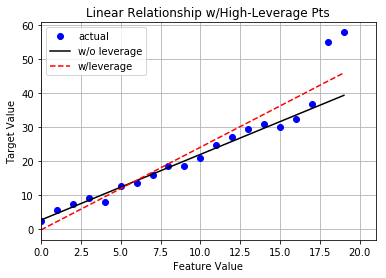

In [93]:
plt.plot(x, y_linear_leverage, 'bo', label='actual')
plt.plot(x, linear.predict(x_reshape), 'k', label='w/o leverage')
plt.plot(x, linear_leverage.predict(x_reshape), 'r--', label='w/leverage')
plt.title('Linear Relationship w/High-Leverage Pts')
plt.xlim(0,21)
plt.xlabel('Feature Value')
plt.ylabel('Target Value')
plt.grid()
plt.legend();

In [94]:
# R^2 for linear model on linear data
print('R^2 w/o leverage: {0:.3f}'.format(linear.score(x_reshape, y)))
print('R^2 w/leverage: {0:7.3f}'.format(linear_leverage.score(x_reshape, y_linear_leverage)))

R^2 w/o leverage: 0.990
R^2 w/leverage:   0.900


In [95]:
# suite of stats
s6 = Stats(x_reshape, y, linear)
pretty_print_stats(s6)

sse:     24.3975
sst:     2502.9934
r^2:     0.9903
adj_r^2: 0.9897


In [96]:
# suite of stats
s7 = Stats(x_reshape, y_linear_leverage, linear_leverage)
pretty_print_stats(s7)

sse:     438.7579
sst:     4373.2096
r^2:     0.8997
adj_r^2: 0.8941


In [ ]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=True)
fig.suptitle('[Residual Plots]')
fig.set_size_inches(12,5)
axes[0].plot(linear.predict(x_reshape), y-linear.predict(x_reshape), 'bo')
axes[0].axhline(y=0, color='k')
axes[0].grid()
axes[0].set_title('No Leverage Pts')
axes[0].set_xlabel('predicted values')
axes[0].set_ylabel('residuals')
axes[1].plot(linear_leverage.predict(x_reshape), y_outlier-linear_leverage.predict(x_reshape), 'ro')
axes[1].axhline(y=0, color='k')
axes[1].grid()
axes[1].set_title('Leverage Pts Present')
axes[1].set_xlabel('predicted values');

### Test Normality

In [97]:
normaltest(y_outlier-linear_leverage.predict(x_reshape))

NormaltestResult(statistic=array([ 25.3995098]), pvalue=array([  3.05187348e-06]))

Fails! The residuals are not normally distributed. This is a key assumption of Linear Regression and we have violated it. 

### Takeaway

The high-leverage points not only act as outliers, they also greatly affect our model's ability to generalize and our confidence in the model itself.

### Solutions

1. Explore the data to understand why these data points exist. Are they true data points or outliers of some kind?
2. Consider imputing or removing them if truly outliers
3. Consider a more robust loss function (e.g. Huber)
4. Consider a more robust algorithm (e.g. RANSAC)

---

## [4] Homoscedasticity of error terms

In [98]:
np.random.seed(20)
x = np.arange(20)
y_homo = [x*2 + np.random.rand(1) for x in range(20)]  ## homoscedastic error
y_hetero = [x*2 + np.random.rand(1)*2*x for x in range(20)]  ## heteroscedastic error

In [99]:
# sklearn expects 2D array so have to reshape x
x_reshape = x.reshape(-1,1)

linear_homo = LinearRegression()
linear_homo.fit(x_reshape, y_homo);

linear_hetero = LinearRegression()
linear_hetero.fit(x_reshape, y_hetero);

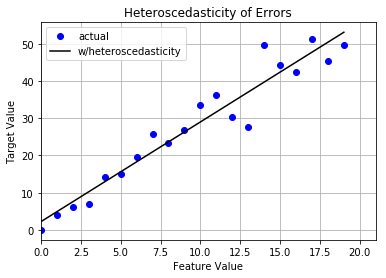

In [100]:
plt.plot(x, y_hetero, 'bo', label='actual')
plt.plot(x, linear_hetero.predict(x_reshape), 'k', label='w/heteroscedasticity')
plt.title('Heteroscedasticity of Errors')
plt.xlim(0,21)
plt.xlabel('Feature Value')
plt.ylabel('Target Value')
plt.grid()
plt.legend();

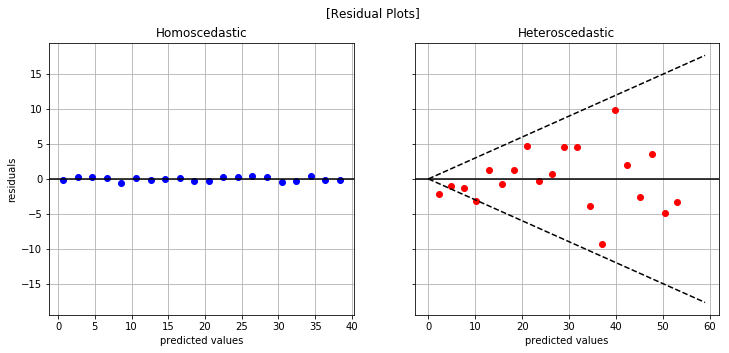

In [101]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=True)
fig.suptitle('[Residual Plots]')
fig.set_size_inches(12,5)
axes[0].plot(linear_homo.predict(x_reshape), y_homo-linear_homo.predict(x_reshape), 'bo')
axes[0].axhline(y=0, color='k')
axes[0].grid()
axes[0].set_title('Homoscedastic')
axes[0].set_xlabel('predicted values')
axes[0].set_ylabel('residuals')
axes[1].plot(linear_hetero.predict(x_reshape), y_hetero-linear_hetero.predict(x_reshape), 'ro')
axes[1].axhline(y=0, color='k')
axes[1].grid()
axes[1].set_title('Heteroscedastic')
axes[1].set_xlabel('predicted values');
axes[1].plot([x*0.3 for x in range(60)], 'k--')
axes[1].plot([-x*0.3 for x in range(60)], 'k--');

### Normality Test

In [102]:
normaltest(y_homo-linear_homo.predict(x_reshape))

NormaltestResult(statistic=array([ 1.71234546]), pvalue=array([ 0.42478474]))

In [103]:
normaltest(y_hetero-linear_hetero.predict(x_reshape))

NormaltestResult(statistic=array([ 1.04126656]), pvalue=array([ 0.59414417]))

### Takeaway

Standard errors, confidence intervals, and hypothesis tests rely on the assumption that errors are homoscedastic. If this assumption is violated, you cannot trust values for the previous metrics!!!

### Possible Solutions

1. Consider log transforming the target values

In [104]:
y_hetero_log = np.log10(np.array(y_hetero) + 1e1)
x_reshape_log = np.log10(np.array(x_reshape) + 1e1)

linear_hetero_log = LinearRegression()
linear_hetero_log.fit(x_reshape, y_hetero_log);

linear_hetero_log_log = LinearRegression()
linear_hetero_log_log.fit(x_reshape_log, y_hetero_log);

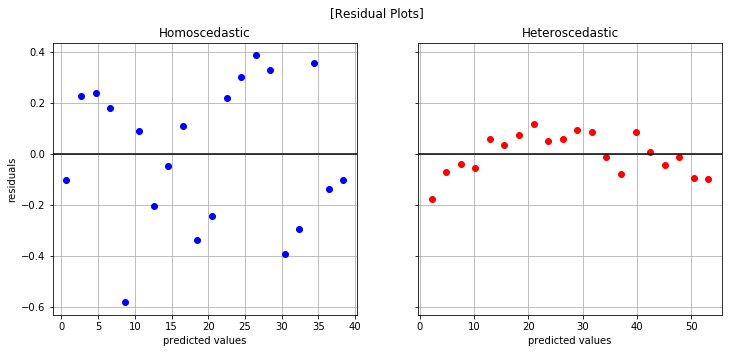

In [105]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=True)
fig.suptitle('[Residual Plots]')
fig.set_size_inches(12,5)
axes[0].plot(linear_homo.predict(x_reshape), y_homo-linear_homo.predict(x_reshape), 'bo')
axes[0].axhline(y=0, color='k')
axes[0].grid()
axes[0].set_title('Homoscedastic')
axes[0].set_xlabel('predicted values')
axes[0].set_ylabel('residuals')
axes[1].plot(linear_hetero.predict(x_reshape), y_hetero_log-linear_hetero_log.predict(x_reshape), 'ro')
axes[1].axhline(y=0, color='k')
axes[1].grid()
axes[1].set_title('Heteroscedastic')
axes[1].set_xlabel('predicted values');

In [106]:
normaltest(y_hetero_log - linear_hetero_log.predict(x_reshape))

NormaltestResult(statistic=array([ 0.96954754]), pvalue=array([ 0.6158365]))

The plot on the right shows we addressed heteroscedasticity but there'a a fair amount of correlation amongst the errors, which brings us to our next assumption.

---

## [5] Uncorrelated error terms

In [107]:
# generate data
np.random.seed(20)
x = np.arange(20)
y_uncorr = [2*x + np.random.rand(1) for x in range(20)]
y_corr = np.sin(x)

In [108]:
# sklearn expects 2D array so have to reshape x
x_reshape = x.reshape(-1,1)

linear_uncorr = LinearRegression()
linear_uncorr.fit(x_reshape, y_uncorr);

linear_corr = LinearRegression()
linear_corr.fit(x_reshape, y_corr);

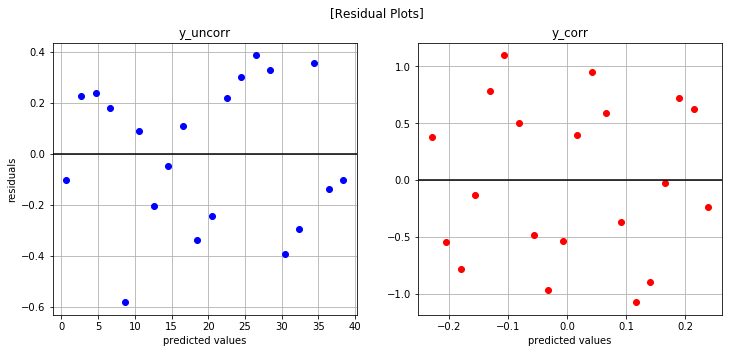

In [109]:
# any patterns?
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False)
fig.suptitle('[Residual Plots]')
fig.set_size_inches(12,5)
axes[0].plot(linear_uncorr.predict(x_reshape), y_uncorr-linear_uncorr.predict(x_reshape), 'bo')
axes[0].axhline(y=0, color='k')
axes[0].grid()
axes[0].set_title('y_uncorr')
axes[0].set_xlabel('predicted values')
axes[0].set_ylabel('residuals')
axes[1].plot(linear_corr.predict(x_reshape), y_corr-linear_corr.predict(x_reshape), 'ro')
axes[1].axhline(y=0, color='k')
axes[1].grid()
axes[1].set_title('y_corr')
axes[1].set_xlabel('predicted values');

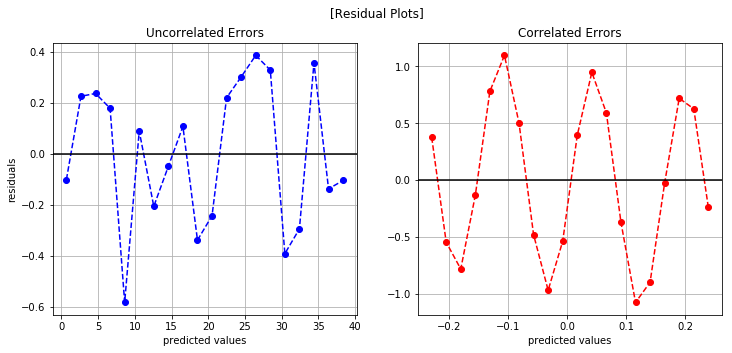

In [110]:
# Now we can see the correlated errors
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False)
fig.suptitle('[Residual Plots]')
fig.set_size_inches(12,5)
axes[0].plot(linear_uncorr.predict(x_reshape), y_uncorr-linear_uncorr.predict(x_reshape), 'bo--')
axes[0].axhline(y=0, color='k')
axes[0].grid()
axes[0].set_title('Uncorrelated Errors')
axes[0].set_xlabel('predicted values')
axes[0].set_ylabel('residuals')
axes[1].plot(linear_corr.predict(x_reshape), y_corr-linear_corr.predict(x_reshape), 'ro--')
axes[1].axhline(y=0, color='k')
axes[1].grid()
axes[1].set_title('Correlated Errors')
axes[1].set_xlabel('predicted values');

### Possible Solutions

1. Forget linear regression. Use time series modeling instead.

Much more on this later. For now, just know it's a problem and Linear Regression does not address it. Linear Regression expects records to be I.I.D.

---

## [6] Independent features

In [111]:
# very nearly independent features
np.random.seed(39)
x1 = np.arange(20) * 2
x2 = np.random.randint(low=0, high=50, size=20)
x_idp = np.vstack((x1,x2))
y = np.add( np.sum(x_idp, axis=0), np.random.randn(20)*5 )  ## y = x1 + x2 + noise

#### 3D Plot

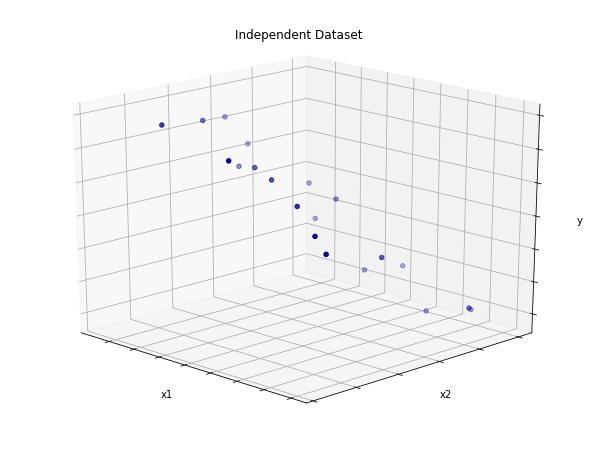

In [112]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=20, azim=135)
ax.scatter(x1, x2, y, c='darkblue')
ax.set_title("Independent Dataset")
ax.set_xlabel("x1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("x2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("y")
ax.w_zaxis.set_ticklabels([])

plt.show()

In [113]:
# create df of linearly dependent features 
dp_df = pd.DataFrame([x1,x2,(x1+x2)]).T

#### Heatmap of feature correlations

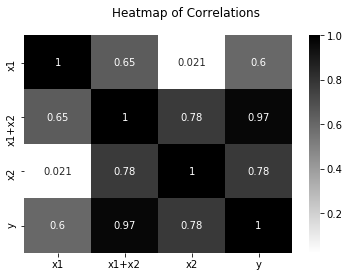

In [114]:
# df + heatmap
import pandas as pd
np.random.seed(39)
d = {'x1':x1, 
     'x2':x2,
     'x1+x2':x1+x2,
     'y':y}
df = pd.DataFrame(d)
sns.heatmap(df.corr(), cmap='binary', annot=True)
plt.suptitle('Heatmap of Correlations');

#### Fit models

In [115]:
lr_idp = LinearRegression()
lr_idp.fit(x_idp.T, y)
print('Bias: {:.4f} | Theta_1: {:.4f} | Theta_2: {:.4f}'.format(lr_idp.intercept_, 
                                                                lr_idp.coef_[0], 
                                                                lr_idp.coef_[1]))

Bias: 0.5829 | Theta_1: 0.9391 | Theta_2: 1.0191


In [116]:
lr_dp = LinearRegression()
lr_dp.fit(dp_df, y)
print('Bias: {:.4f} | Theta_1: {:.4f} | Theta_2: {:.4f} | Theta_3: {:.4f}'.format(lr_dp.intercept_, 
                                                                lr_dp.coef_[0], 
                                                                lr_dp.coef_[1],
                                                                lr_dp.coef_[2]))

Bias: 0.5829 | Theta_1: 0.2863 | Theta_2: 0.3664 | Theta_3: 0.6527


#### Stats

In [117]:
s8 = Stats(x_idp.T, y, lr_idp)
s9 = Stats(dp_df, y, lr_dp)

In [118]:
# linearly INDEPENDENT features
pretty_print_stats(s8)

sse:     361.5308
sst:     6898.6751
r^2:     0.9476
adj_r^2: 0.9414


In [119]:
# linearly DEPENDENT features - notice adj_R^2
pretty_print_stats(s9)

sse:     361.5308
sst:     6898.6751
r^2:     0.9476
adj_r^2: 0.9378
